In [5]:
import json
import pandas as pd
import numpy as np

import os
import datetime
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.imagenet_utils import decode_predictions
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

from keras.initializers import glorot_normal

import math
from keras.datasets import cifar100
from scipy.cluster.vq import whiten

import glob

%matplotlib inline

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [6]:
def load_image(filename, img_rows=100, img_cols=100, plot=True):
    try:
        # load an image in PIL format
        original = load_img(filename, target_size=(img_rows, img_cols))

        # convert the PIL image to a numpy array
        # IN PIL - image is in (width, height, channel)
        # In Numpy - image is in (height, width, channel)
        numpy_image = img_to_array(original)

        # Convert the image / images into batch format
        # expand_dims will add an extra dimension to the data at a particular axis
        # We want the input matrix to the network to be of the form (batchsize, height, width, channels)
        # Thus we add the extra dimension to the axis 0.
        image_batch = np.expand_dims(numpy_image, axis=0)
        if plot: plt.imshow(np.uint8(image_batch[0]))
        return image_batch
    except IOError:
        # image_list.remove(filename)
        print("removed")
        return np.array([])

In [9]:
def fetch_data (file_path, img_rows=100, img_cols=100):
    # 2. Auto-iterate using the query syntax
    #    https://developers.google.com/drive/v2/web/search-parameters
    file_list = glob.glob("./data/input/" + file_path + "/*.JPEG")
  
    final_images = []
    batches = []
    for f in file_list[0:10]:
        curr_image = load_image(f, img_rows, img_cols)
        if curr_image.size != 0:
            final_images.append(f)
            batches.append(curr_image)
    return final_images, batches

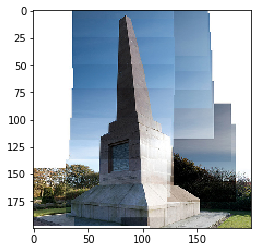

In [10]:
img_rows, img_cols = 200, 200
input_path = "ILSVRC2012_Validation"
final_images, batches = fetch_data(input_path, img_rows, img_cols)

In [13]:
final_images

['./data/input/ILSVRC2012_Validation/ILSVRC2012_val_00002199.JPEG',
 './data/input/ILSVRC2012_Validation/ILSVRC2012_val_00006094.JPEG',
 './data/input/ILSVRC2012_Validation/ILSVRC2012_val_00000177.JPEG',
 './data/input/ILSVRC2012_Validation/ILSVRC2012_val_00008280.JPEG',
 './data/input/ILSVRC2012_Validation/ILSVRC2012_val_00000196.JPEG',
 './data/input/ILSVRC2012_Validation/ILSVRC2012_val_00007559.JPEG',
 './data/input/ILSVRC2012_Validation/ILSVRC2012_val_00003755.JPEG',
 './data/input/ILSVRC2012_Validation/ILSVRC2012_val_00001826.JPEG',
 './data/input/ILSVRC2012_Validation/ILSVRC2012_val_00009337.JPEG',
 './data/input/ILSVRC2012_Validation/ILSVRC2012_val_00002278.JPEG']

# Neural network test

In [0]:
(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')

In [40]:
x_train.shape

(50000, 32, 32, 3)

In [0]:
def format_data(x_train, x_test):
  x_train = x_train.astype('float32')/255.
  x_test = x_test.astype('float32')/255.
  return x_train, x_test

In [0]:
x_train, x_test = format_data(x_train, x_test)

Does Whitening work when it is done independently on x_train and x_test? (e.g., should the same whitening factor be used on x_test as on x_train)

In [0]:
def filter_for_classes(X, y, classes):
  mask = np.isin(y, classes)
  mask = mask.reshape(len(mask))
  return X[mask], y[mask]


In [0]:
classes_to_retain = range(0,100)
num_classes = len(classes_to_retain)
x_train, y_train = filter_for_classes(x_train, y_train, classes_to_retain)
x_test, y_test = filter_for_classes(x_test,y_test,classes_to_retain)

In [45]:
x_train.shape

(50000, 32, 32, 3)

In [0]:
def whiten_data(x_train, x_test):
  X = np.append(x_train, x_test, axis=0)
  X_white = whiten(X).reshape(X.shape)
  x_train_white = X_white[0:x_train.shape[0]]
  x_test_white = X_white[x_train.shape[0]:x_train.shape[0]+x_test.shape[0]]
  return x_train_white, x_test_white

In [0]:
x_train, x_test = whiten_data(x_train,x_test)

I actually think most of the reshaping above is unnecessary because we actually need a 50000, 3\*32\*32 shape

In [0]:
x_train,x_val, y_train, y_val = train_test_split(x_train, y_train)

In [0]:
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)
y_val_categorical = to_categorical(y_val)

In [0]:
datagen = keras.preprocessing.image.ImageDataGenerator(featurewise_center=False, samplewise_center=False, featurewise_std_normalization=False, samplewise_std_normalization=False, zca_whitening=False, zca_epsilon=1e-06, rotation_range=0.0, width_shift_range=0.0, height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_range=0.0, channel_shift_range=0.0, fill_mode='nearest', cval=0.0, horizontal_flip=False, vertical_flip=False, rescale=None, preprocessing_function=None, data_format=None, validation_split=0.0)


In [0]:
# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(x_train)

## Model Definition

I will start by "randomly" creating models.

In [0]:
from keras.applications import InceptionV3
from keras import Model
models = []
input_shape = (32,32,3)

Model from https://andrewkruger.github.io/projects/2017-08-05-keras-convolutional-neural-network-for-cifar-100#the-model

In [0]:
model = Sequential()
model.add(Conv2D(128, (3, 3), padding='same',
        input_shape=x_train.shape[1:]))
model.add(Activation('elu'))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(Activation('elu'))
model.add(Conv2D(256, (3, 3)))
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, (3, 3), padding='same'))
model.add(Activation('elu'))
model.add(Conv2D(512, (3, 3)))
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('elu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))



In [0]:
batch_size=20
epochs = 10
models.append({"model":model, "batch":batch_size, "epochs":epochs})

More random model

In [55]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3))`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same")`
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3))`
  if sys.path[0] == '':


In [0]:
batch_size=20
epochs = 20
# models.append({"model":model, "batch":batch_size, "epochs":epochs})

Incoporate batch feeding via data flow : ImageFlowGenerator

In [0]:
history = []
lr = 0.0001
for model in models:
    model["model"].compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(lr=lr),
              metrics=['accuracy'])

In [0]:
for model in models:  
  history.append(model["model"].fit_generator(datagen.flow(x_train, y_train_categorical,
          batch_size=model["batch"]),
          steps_per_epoch = len(x_train)/model["batch"],
          epochs=model["epochs"],
          verbose=1,
          validation_data = (x_val, y_val_categorical)))
  print ("Model success")

Epoch 1/10
 659/1875 [=========>....................] - ETA: 1:05 - loss: 4.3200 - acc: 0.0526

In [0]:
# for model in models:
#   history.append(model["model"].fit(x_train, y_train_categorical,
#           batch_size=model["batch"],
#           epochs=model["epochs"],
#           verbose=1,
#           validation_data = (x_val, y_val_categorical)))
# print ("Model success")

In [111]:
for model in models:
  score = model["model"].evaluate(x_test, y_test_categorical, verbose=0)
  print('Test loss:', score[0])
  print('Test accuracy:', score[1])

Test loss: 3.373948706817627
Test accuracy: 0.1986


In [0]:
now = datetime.datetime.now()
prefix = now.strftime("%Y%m%d_%H%M")

In [0]:
id = "1JBT_mnTQVnJkXL31ODPRCw7tTAQKakAs"
folder_id = create_output_folder(id, prefix, drive)

In [0]:
def save_input_data():
  create_output_file(folder_id, np.array2string(x_test), "test_image_data.txt", drive)
  create_output_file(folder_id, np.array2string(y_test), "test_image_label.txt", drive)
  create_output_file(folder_id, np.array2string(x_train), "train_image_data.txt", drive)
  create_output_file(folder_id, np.array2string(y_train), "train_image_label.txt", drive)

  for model_ind in range(len(models)):
    model = models[model_ind]["model"]
    create_output_file(folder_id, model.to_json(), "image_model_{}.json".format(model_ind), drive)
    create_output_file(folder_id, np.array2string(np.array(model.weights)), "image_model_{}_weights.txt".format(model_ind), drive)


Define a function to print the pictures that were falsely classified

In [0]:
def print_false_predicted(trained_model, image_input, target):
    predict = trained_model.predict_classes(image_input) + 1
    f_images = [predict[i] != target[i] for i in range(len(predict))]
    for img in image_input[f_images]:
        plt.imshow(np.uint8(img*255))
        plt.show()

And apply the function to test or training data

In [0]:
from keras.layers import InputLayer
import copy

In [0]:
def cut_model (input_model):
    dense_layer_count = 0
    count = False
    model_length = len(input_model.layers)
    output_model = Sequential()
    output_config = []
    for index in range(model_length):
      if (count == True):
          output_config.append(layer.get_config())
          input_model.pop()
      else: layer = input_model.layers[index]
      if layer.name.startswith('flatten'):
          count = True
          output_model.add(InputLayer(input_shape=layer.output_shape))          
               
    print (output_config)
    # return output_model

In [118]:
# output_models = []
for model in models:
  cut_model(model["model"])
  # output_models.append(out)

[{'name': 'flatten_4', 'trainable': True, 'data_format': 'channels_last'}, {'name': 'flatten_4', 'trainable': True, 'data_format': 'channels_last'}, {'name': 'flatten_4', 'trainable': True, 'data_format': 'channels_last'}, {'name': 'flatten_4', 'trainable': True, 'data_format': 'channels_last'}, {'name': 'flatten_4', 'trainable': True, 'data_format': 'channels_last'}]


In [0]:
def create_output_separate_train_val ():
  for model_ind in range(len(models)):
    model = models[model_ind]

    model["pred_train"] = model["model"].predict(x_train)
    model["pred_val"] = model["model"].predict(x_val)
    model["pred_test"] = model["model"].predict(x_test)
    model["pred_train_with_target"] = np.array([np.append(model["pred_train"][i], y_train[i]) for i in range(len(model["pred_train"]))])
    model["pred_val_with_target"] = np.array([np.append(model["pred_val"][i], y_val[i]) for i in range(len(model["pred_val"]))])
    model["pred_test_with_target"] = np.array([np.append(model["pred_test"][i], y_test[i]) for i in range(len(model["pred_test"]))])
    
  for model_ind in range(len(models)):
    model = models[model_ind]
    create_output_file(folder_id, model["model"].to_json(), "image_model_{}_cut.json".format(model_ind), drive)
    create_output_file(folder_id, np.array2string(np.array(model["model"].weights)), "image_model_{}_cut_weights.txt".format(model_ind), drive)
    
    f_name = "{}_pred_train_with_target_cut_data.npy".format(model_ind)
    np.save(f_name, model["pred_train_with_target"])
    uploaded = drive.CreateFile({'title': f_name, "parents":  [{"id": folder_id}]})
    uploaded.SetContentFile(f_name)
    uploaded.Upload()
    print('Uploaded file with ID {}'.format(uploaded.get('id')))
    f_name = "{}_pred_val_with_target_cut_data.npy".format(model_ind)
    np.save(f_name, model["pred_val_with_target"])
    uploaded = drive.CreateFile({'title': f_name, "parents":  [{"id": folder_id}]})
    uploaded.SetContentFile(f_name)
    uploaded.Upload()
    print('Uploaded file with ID {}'.format(uploaded.get('id')))
    
    f_name = "{}_pred_test_with_target_cut_data.npy".format(model_ind)
    np.save(f_name, model["pred_test_with_target"])
    uploaded = drive.CreateFile({'title': f_name, "parents":  [{"id": folder_id}]})
    uploaded.SetContentFile(f_name)
    uploaded.Upload()
    print('Uploaded file with ID {}'.format(uploaded.get('id')))
    
    
    
 

In [136]:
print(prefix)

20180511_1400


In [137]:
create_output_separate_train_val()

Uploaded file with ID 1F1ON2APyRZBtLpxPHsAYk6hzkucXmz4y
Uploaded file with ID 19rYJTNXE1FslLCIXOqimtA9aK9Sd-Qn1
Uploaded file with ID 19mAucp15sh2x59K2ujxSpi91JnBOwobb
